# CLIPasso応用_感情認識_プレーン画像
**概要**        
・元画像データセットでの学習結果と、CLIPassoで生成したスケッチ画像データセットでの学習結果との比較を目指した
・顔画像から[happy, natural, angry, sad]の4つの感情を認識をする  
・FER-2013データセットを使用  
・VGG16への転移学習を行う  
・trainデータ、validationデータ、testデータにそれぞれの感情ごとに事前にフォルダ分割が必要    
・学習結果（trainとvalのloss表示）とテストデータでの認識結果を示す  

**リファレンス**  
[「少ないデータで転移学習を用いて画像内の表情を分類する」](https://github.com/zarakima/face-classification)  
[FER-2013](https://www.kaggle.com/datasets/msambare/fer2013)  
[CLIPasso](https://clipasso.github.io/clipasso/) 

## データセットの準備  

・各クラスごとに学習(train)420枚/バリデーション(validation)/予測(test)150枚  
・FER-2013のtrainフォルダ内のデータをtrainに、testフォルダ内のデータをvalidation/testに使用     
・Google driveに以下のディレクトリ構成

```
plain_dataset
├── train
│   ├── happy
│   ├── neutral
│   ├── sad
│   └── angry
├── validation
│   ├── happy
│   ├── neutral
│   ├── sad
│   └── angry
└── test
    ├── happy
    ├── neutral
    ├── sad
    └── angry
```

## Google drive連携

In [1]:
# datasetディレクトリ
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Utilsコード

In [2]:
# # google drivenのファイル数カウントに使用
# import os
 
# # ファイル数を調べたいフォルダのパス
# path = '/content/drive/My Drive/world_model/test_emotion_detection/validation/angry'
 
# # フォルダ内の全ファイル名をリスト化
# files = os.listdir(path)
 
# # リストの長さ（ファイル数）を取得
# count = len(files)
 
# # ファイル数を確認
# print(count)

## 必要なライブラリのインポート

In [3]:
import os
import sys
import glob

import keras
import numpy as np
import matplotlib.pyplot as plt

from keras import optimizers
from keras.layers import Dense, Flatten, Input, Activation, add
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# 学習済みネットワーク
from keras.applications.vgg16 import VGG16\

## ハイパーパラメータの設定

In [4]:
# 分類
emotions = ['happy', 'neutral', 'angry', 'sad'] # 分類したい項目名（ディレクトリ名）
emotion_count = len(emotions)

image_width, image_height = 150, 150

dataset_path = '/content/drive/Shareddrives/SketchWorldModels/emotionclassification/plain_datasets'

train_data_path = str(dataset_path) + '/train' 
validation_data_path = str(dataset_path) + '/validation' 
test_data_path = str(dataset_path) + '/test' 

# 重みデータを保存するディレクトリ
result_dir = '/content/drive/Shareddrives/SketchWorldModels/emotionclassification'
# 重みデータのファイル名 (.h5に注意)
weights_file = 'weights_plain.h5'

# データの枚数
train_data_count = 420
validation_data_count = 140

# バッチサイズ、エポック数
batch_size = 8
epoch_count = 50

## データの生成（ジェネレータ）

In [5]:
# データ生成
datagen = ImageDataGenerator(
    rescale = 1.0/255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.39,
    horizontal_flip=True,
    samplewise_center=False,
    samplewise_std_normalization =False,
    zca_whitening=False)

In [6]:
generator_train = datagen.flow_from_directory(
    train_data_path,
    target_size=(image_width, image_height),
    color_mode='rgb',
    classes=emotions,
    class_mode='categorical', 
    batch_size=batch_size,
    shuffle=True)

generator_validation = datagen.flow_from_directory(
    validation_data_path, 
    target_size=(image_width, image_height),
    color_mode='rgb',
    classes=emotions,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True)

Found 1680 images belonging to 4 classes.
Found 580 images belonging to 4 classes.


## 学習済みVGG16の読み込みと全結合層の作成

In [7]:
# VGG16学習済みモデルの読み込み(RGB)
input_tensor = Input(shape=(image_width, image_height, 3))
learned_model = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

# 全結合層の作成
full_model = Sequential()
full_model.add(Flatten(input_shape=learned_model.output_shape[1:]))
full_model.add(Dense(256, activation='relu',
                    kernel_initializer='he_normal'))
full_model.add(Dense(64, activation='relu',
                    kernel_initializer='he_normal'))
full_model.add(Dense(emotion_count, activation='softmax'))

# 学習済みデータと全結合層を結合
model = Model(inputs=learned_model.input, outputs=full_model(learned_model.output))

# 全結合層直前までの層を学習しないようにする
for layer in learned_model.layers[:15]:
    layer.trainable = False

# 学習処理の設定
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=optimizers.gradient_descent_v2.SGD(learning_rate=1e-3, momentum=0.9),
    metrics=['accuracy'])

58900480/58889256 [==============================] - 2s 0us/step


## 学習
・実行時間はGoogle Clab Pro GPU/High-RAMで15分ほど

In [8]:
# 学習
result = model.fit(
    generator_train,
    steps_per_epoch=train_data_count // batch_size,
    epochs=epoch_count,
    validation_data=generator_validation,
    validation_steps=validation_data_count // batch_size)

# 重みを保存
model.save_weights(os.path.join(result_dir, weights_file))

Epoch 1/50
52/52 [==============================] - 358s 7s/step - loss: 1.4667 - accuracy: 0.2740 - val_loss: 1.3853 - val_accuracy: 0.2941
Epoch 2/50
52/52 [==============================] - 266s 5s/step - loss: 1.3686 - accuracy: 0.3101 - val_loss: 1.3558 - val_accuracy: 0.3235
Epoch 3/50
52/52 [==============================] - 206s 4s/step - loss: 1.3638 - accuracy: 0.3221 - val_loss: 1.3511 - val_accuracy: 0.3015
Epoch 4/50
52/52 [==============================] - 154s 3s/step - loss: 1.3200 - accuracy: 0.3678 - val_loss: 1.2989 - val_accuracy: 0.3162
Epoch 5/50
52/52 [==============================] - 114s 2s/step - loss: 1.3058 - accuracy: 0.3822 - val_loss: 1.2772 - val_accuracy: 0.4338
Epoch 6/50
52/52 [==============================] - 84s 2s/step - loss: 1.2502 - accuracy: 0.4111 - val_loss: 1.2661 - val_accuracy: 0.3824
Epoch 7/50
52/52 [==============================] - 68s 1s/step - loss: 1.2231 - accuracy: 0.4255 - val_loss: 1.2597 - val_accuracy: 0.4338
Epoch 8/50
52/5

## 学習結果の表示

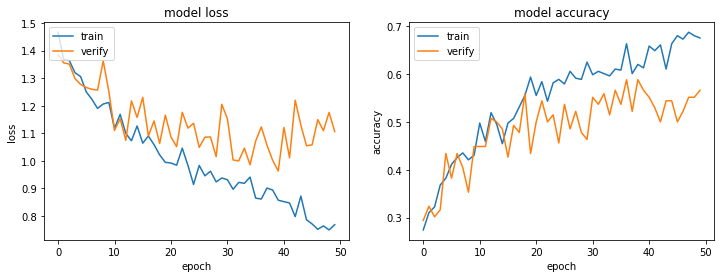

In [9]:
fig = plt.figure(figsize=(12,4))

# subplot
# loss
sub_loss = fig.add_subplot(1,2,1)
sub_loss.plot(result.history['loss'])
sub_loss.plot(result.history['val_loss'])
sub_loss.set_title('model loss')
sub_loss.set_ylabel('loss')
sub_loss.set_xlabel('epoch')
sub_loss.legend(['train', 'verify'], loc='upper left')

#Accuracy
sub_acc = fig.add_subplot(1,2,2)
sub_acc.plot(result.history['accuracy'])
sub_acc.plot(result.history['val_accuracy'])
sub_acc.set_title('model accuracy')
sub_acc.set_ylabel('accuracy')
sub_acc.set_xlabel('epoch')
sub_acc.legend(['train', 'verify'], loc='upper left')

## テストデータでの予測

In [10]:
def test_predict(filepath_list):
    
    # 各クラスの予測画像枚数
    num_test = 5

    count = 0
    for i in filepath_list:
        # 画像を読み込んで4次元テンソルへ変換
        img = image.load_img(i, target_size=(image_height, image_width))
        xarray = image.img_to_array(img)
        x = np.expand_dims(xarray, axis=0)
        # テストデータも正規化
        x = x / 255.0

        # 予測 入力は1枚の画像なので[0]のみ
        pred = model.predict(x)[0]
        
        # 描画 topの数だけ予測確率が高い結果を出力
        fig = plt.figure(figsize=(2,2))
        top = 3
        top_indices = pred.argsort()[-top:][::-1]
        result = [(emotions[i], pred[i]) for i in top_indices]
        [print(x) for x in result]
        plt.imshow(img)
        plt.show()
        
        print('------------------------------------')

        count += 1
        if count == num_test: break



<<HAPPY>>

('happy', 0.62061375)
('angry', 0.3692898)
('sad', 0.007096678)


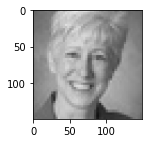

------------------------------------
('happy', 0.9998305)
('angry', 0.000114451315)
('sad', 3.3659635e-05)


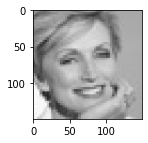

------------------------------------
('happy', 0.82739544)
('neutral', 0.104295306)
('angry', 0.038721487)


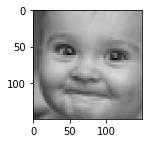

------------------------------------
('happy', 0.9686215)
('sad', 0.017709421)
('neutral', 0.011441566)


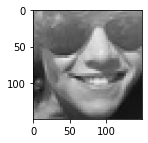

------------------------------------
('happy', 0.9027074)
('angry', 0.096926466)
('sad', 0.00025903984)


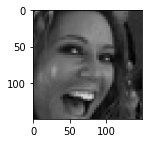

------------------------------------


<<NEUTRAL>>

('angry', 0.410382)
('sad', 0.33982578)
('neutral', 0.24968998)


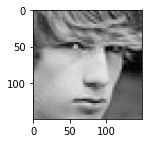

------------------------------------
('neutral', 0.80787003)
('sad', 0.10856129)
('angry', 0.055101905)


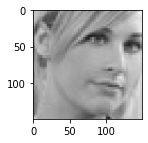

------------------------------------
('neutral', 0.87270355)
('happy', 0.06649098)
('sad', 0.039725926)


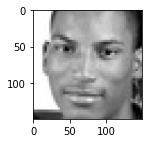

------------------------------------
('sad', 0.5278809)
('angry', 0.369553)
('neutral', 0.08822442)


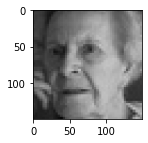

------------------------------------
('neutral', 0.689104)
('sad', 0.24585001)
('angry', 0.062421132)


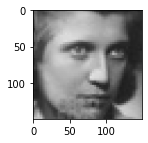

------------------------------------


<<ANGRY>>

('sad', 0.5394476)
('neutral', 0.2636469)
('angry', 0.19460219)


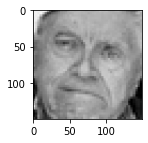

------------------------------------
('angry', 0.99488187)
('sad', 0.0047767963)
('happy', 0.0002060918)


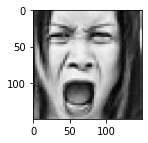

------------------------------------
('angry', 0.9982109)
('happy', 0.0015871077)
('sad', 0.00018938215)


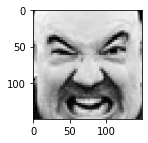

------------------------------------
('sad', 0.4672433)
('neutral', 0.2953189)
('angry', 0.23725376)


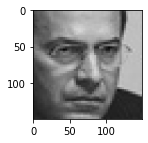

------------------------------------
('angry', 0.9719263)
('neutral', 0.017010335)
('sad', 0.0063873525)


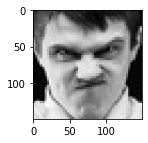

------------------------------------


<<SAD>>

('sad', 0.46840647)
('neutral', 0.43951738)
('angry', 0.076336905)


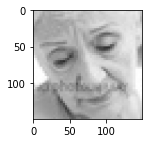

------------------------------------
('neutral', 0.39017814)
('sad', 0.3406769)
('happy', 0.21707222)


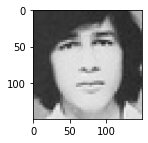

------------------------------------
('sad', 0.5088736)
('neutral', 0.25684607)
('angry', 0.22600006)


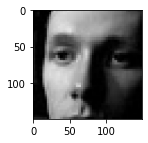

------------------------------------
('sad', 0.46084258)
('angry', 0.29708907)
('neutral', 0.21852107)


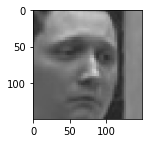

------------------------------------
('neutral', 0.5737007)
('sad', 0.27663967)
('angry', 0.14904094)


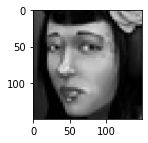

------------------------------------


In [11]:
for x in emotions:
    print('\n\n<<'+ str(x).upper() + '>>\n')
    filepath_list = glob.glob(str(test_data_path)  + '/' + str(x) + '/*')
    test_predict(filepath_list)